# Generative Adversarial Networks in Slanted Land

In this notebook, we build a very simple pair of GANs.
- The dataset is a dataset of 2x2 black and white images, where the images we want to generate (the faces) are backwards diagonals (\\)
- The neural networks only have one layer.

### Imports

In [1]:
# Imports
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
%matplotlib inline

### Plotting function

In [2]:
# Drawing function

def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

# Examples of faces

In the video, we've defined the faces as backwards diagonals. Here are some examples.

In [17]:
np.random.uniform(0, 0.4, (2,10))

array([[0.24751143, 0.30172677, 0.29371531, 0.05807728, 0.20474401,
        0.17176147, 0.34822026, 0.22333615, 0.15877415, 0.02742056],
       [0.13076685, 0.08682121, 0.04054302, 0.08804142, 0.23450284,
        0.19159468, 0.02821351, 0.35343034, 0.01833677, 0.03845922]])

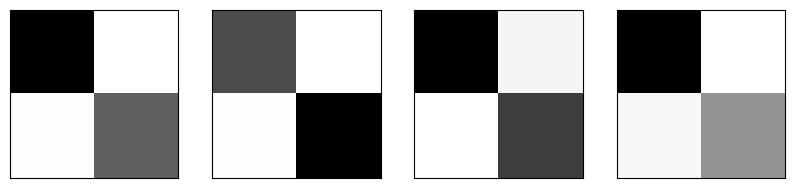

In [55]:
# Examples of faces

# Creating dataset of 100 faces
firsts = np.random.uniform(0.6, 1, (1,100))
seconds_thirds = np.random.uniform(0, 0.4, (2,100))
fourth = np.random.uniform(0.6, 1, (1,100))
faces = np.concatenate((firsts, seconds_thirds, fourth), axis=0).T

random_faces = faces[np.random.choice(faces.shape[0], size=4)]
_ = view_samples(random_faces, 1, 4)

# Examples of noise
The following are randomly generated images, which don't correspond to faces.

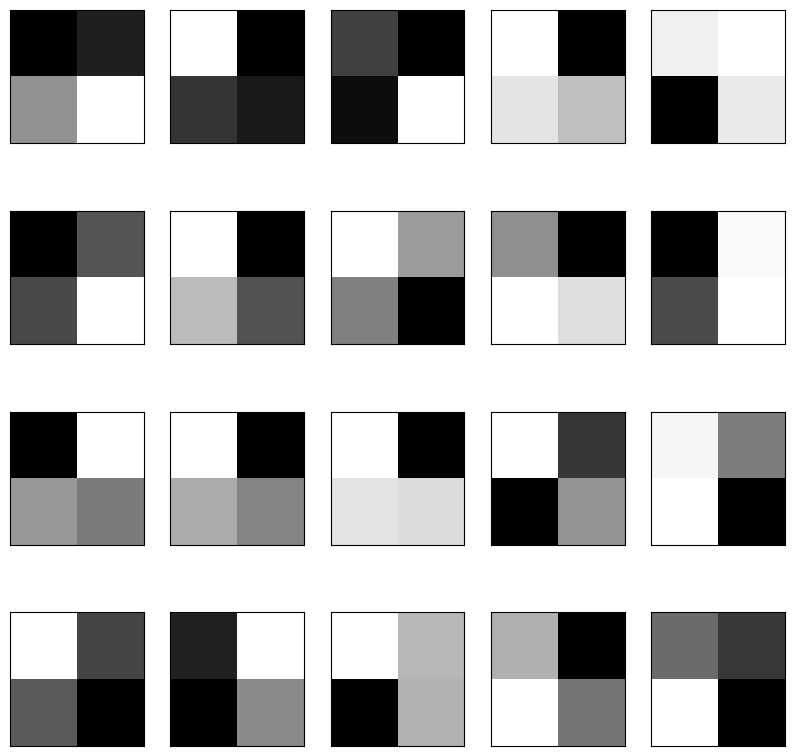

In [56]:
# Examples of noisy images
noise = [np.random.randn(2,2) for i in range(20)]
# def generate_random_image():
    # return [np.random.random(), np.random.random(), np.random.random(), np.random.random()]

_ = view_samples(noise, 4,5)

# Building the neural networks

In [57]:
# The sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

## The Discriminator

<img src="discriminator_math.png" />

In [58]:
class Discriminator():
    def __init__(self):
        #self.weights = np.array([0.0 for i in range(4)])
        #self.bias = 0.0
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
    
    def forward(self, x):
        # Forward pass
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_from_image(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    def derivatives_from_image(self, image):
        prediction = self.forward(image)
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias
    
    def update_from_image(self, x):
        ders = self.derivatives_from_image(x)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-prediction)
    
    def derivatives_from_noise(self, noise):
        prediction = self.forward(noise)
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias
    
    def update_from_noise(self, noise):
        ders = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

## The Generator
<img src="generator_math.png" />

In [59]:
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])

    def forward(self, z):
        # Forward pass
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)  , wait isnt this comment wrong? we want the prediction to be 1.
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)  
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        error_before = self.error(z, discriminator)
        ders = self.derivatives(z, discriminator)
        self.weights -= learning_rate * ders[0]
        self.biases -= learning_rate * ders[1]
        error_after = self.error(z, discriminator)   # why calculate error_after?

# Training

In [91]:
# Set random seed
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces[:4]:   # looping over each sample. can be vectorized. and why use such a small dataset?
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

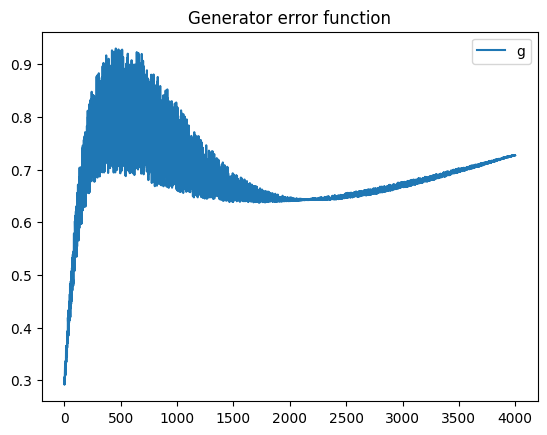

Text(0.5, 1.0, 'Discriminator error function')

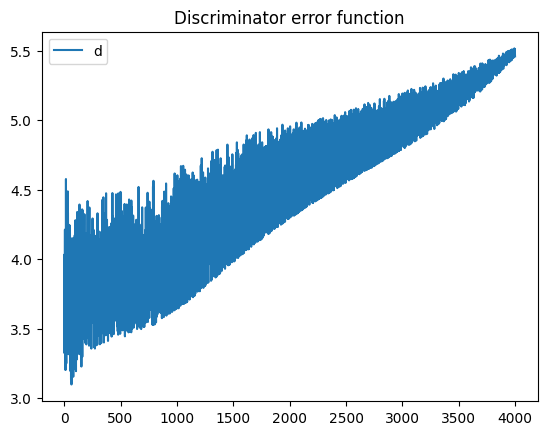

In [92]:
import matplotlib.pyplot as plt
plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

# Generating images

[0.86781891 0.05182893 0.0840668  0.93296708]
[0.8648625  0.0510616  0.0850554  0.93026453]
[0.87270278 0.05315398 0.08241561 0.93732514]
[0.86532912 0.05118104 0.08489989 0.9306943 ]


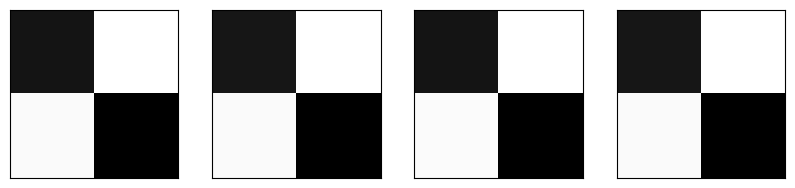

In [93]:
generated_images = []
for i in range(4):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
    
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

# Studying the weights and biases of the Generator and Discriminator

In [94]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 0.37941914  0.2336754  -0.18977953  0.63046557]
Generator biases [ 1.76901374 -2.9760551  -2.33191265  2.44575679]


In [95]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.08981193 -0.05869293 -0.01276742 -0.04095412]
Discriminator bias -0.11617427358852273


# Coding it by myself

In [ ]:
class Discriminator():
    def __init__(self):
        self.W = np.random.normal(size=(1,4))
        self.bias = np.random.normal(size=(1,1))
        self.losses = []

    def forward(self, x):
        assert x.shape == (4,1)
        return sigmoid(self.W @ x + self.bias)
    
    def loss(self, x, y):
        J = - (y * np.log(x) + (1 - y) * np.log(1 - x))   # x = D(x), y = 1 for real images from train set
        D.losses.append(J)                                # x = D(G(z)), y = 0 for images generated by generator

    def gradients(self, D_x, y, x):
        """
        D_x: D(x) discriminator output
        y: true label (1 for real, 0 for fake)
        x: input image (4,1)
        """
        dw = (D_x - y) * x.T
        db = D_x - y
        return dw, db
    
    def update(self, D_x, y, x, lr):
        dW, db = self.gradients(D_x, y, x)
        self.W -= lr * dW
        self.bias -= lr * db



class Generator():
    def __init__(self):
        self.W = np.random.normal(size=(4,1))
        self.bias = np.random.normal(size=(4,1))

    def forward(self, z):
        assert z.shape == (1,1)
        return sigmoid(self.W * z + self.bias)
    
    def loss(self, D_G_z):
        return - np.log(D_G_z)   # we want D(G(z)) to be 1

    def gradients(self, D, z):
        """
        D: Discriminator object
        z: input noise (1,1)
        """
        G_z = self.forward(z) # (4,1)
        D_G_z = D.forward(G_z) # scalar
        factor = (D_G_z - 1) * D.W.T * G_z * (1 - G_z) # (4,1)
        dW = factor * z
        db = factor
        return dW, db
    
    def update(self, dW, db, lr):
        self.W -= lr * dW
        self.bias -= lr * db

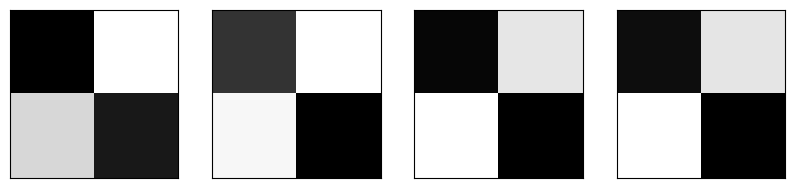

In [105]:
random_faces = faces[np.random.choice(faces.shape[0], size=4)]
_ = view_samples(random_faces, 1, 4)

In [ ]:
np.random.seed(42)
lr = 0.01
epochs = 100

D = Discriminator()
G = Generator()

for epoch in range(epochs):

    for face in random_faces:
        face = face.reshape((4,1))

        # Train Discriminator on real image
        D_x = D.forward(face)
        D.losses.append(D.loss(D_x, 1)) # error on real image
        D.update(D_x, 1, face, lr)